In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from operator import itemgetter

In [17]:
def gru(path, train_test_split_ratio, gru_config, figsize=(40, 15), seq_len=(1,14), attribute='Close'):
  df = pd.read_csv(path)
  display(df.head())

  train_set, test_set = train_test_split(df, test_size=train_test_split_ratio, shuffle=False)

  train_dates = pd.to_datetime(train_set['Date'])
  test_dates = pd.to_datetime(test_set['Date'])

  epochs, batch_size, dropout = itemgetter('epochs', 'batch_size', 'dropout')(gru_config)

  #Variables for training
  cols = list(df)[1:6]
  df_for_training = train_set[cols].astype(float)
  df_for_testing = test_set[cols].astype(float)

  trainX, trainY = [], []
  testX, testY = [], []

  #GRU uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
  # normalize the dataset
  scaler = StandardScaler()
  scaler = scaler.fit(df_for_training)
  df_for_training_scaled = scaler.transform(df_for_training)
  df_for_testing_scaled = scaler.transform(df_for_testing)

  n_future = seq_len[0]   # Number of days we want to look into the future based on the past days.
  n_past = seq_len[1]  # Number of past days we want to use to predict the future.

  testY_cutoff = test_dates[test_dates.index[0] + n_past]

  index_cutoff = test_dates.index[0] + n_past

  print(f'testY_cutoff is {testY_cutoff}')

  attribute_to_col_map = {
      'Open': 0,
      'High': 1,
      'Low': 2,
      'Close': 3,
      'Adj Close': 4
  }

  column = attribute_to_col_map[attribute]

  # slice the training set
  for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, column])

  # slice the testing set
  for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
      testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
      testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, column])

  trainX, trainY = np.array(trainX), np.array(trainY)
  testX, testY = np.array(testX), np.array(testY)

  # create the model
  model = Sequential()
  model.add(GRU(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))

  model.add(GRU(32, activation='tanh', return_sequences=False))
  model.add(Dropout(dropout))
  model.add(Dense(trainY.shape[1]))

  model.compile(optimizer='adam', loss='mae')
  model.summary()

  # fit the model
  history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.legend()

  #Make prediction
  predictions = model.predict(testX) 

  predictions_copies = np.repeat(predictions, df_for_training.shape[1], axis=-1)
  y_pred_future = scaler.inverse_transform(predictions_copies)[:,0]

  original = df[['Date', attribute]]
  original['Date']=pd.to_datetime(original['Date'])
  original = original.loc[original['Date'] >= testY_cutoff]

  df_forecast = pd.DataFrame(columns=['Date', attribute])
  df_forecast['Date'] = test_dates
  df_forecast = df_forecast.loc[df_forecast['Date'] >= testY_cutoff]
  df_forecast[attribute] = y_pred_future

  complete = df[['Date', attribute]]
  complete['Date']=pd.to_datetime(complete['Date'])



  plt.figure(figsize=figsize)
  plt.plot(range(0, 9909), complete[attribute].to_list(), 'r', label='Label 1')
  plt.plot(range(index_cutoff, 9909), df_forecast[attribute].to_list(), 'g', label='Label 2')
  plt.plot(range(index_cutoff, 9909), original[attribute].to_list(), 'b', label='Label 3')

  return {
      'forecast': df_forecast,
      'original': original,
      'complete': complete
  }

In [11]:
path = '/content/drive/MyDrive/Colab Notebooks/seng474/AAPL.csv'
train_test_split_ratio = 0.1

In [14]:
lstm_config = {
    'epochs': 20,
    'batch_size': 16,
    'dropout': 0.2
}

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


testY_cutoff is 2016-05-16 00:00:00
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 14, 64)            13632     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,073
Trainable params: 23,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
501/501 [==============================] - 14s 19ms/step - loss: 0.0498 - val_loss: 0.1865
Epoch 2/20
501/501 [========================

<ipython-input-10-af89978d79eb>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
<ipython-input-10-af89978d79eb>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete['Date']=pd.to_datetime(complete['Date'])


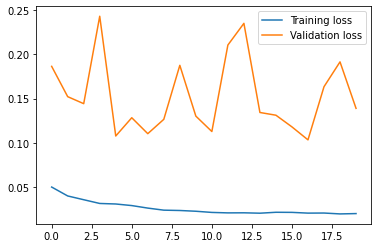

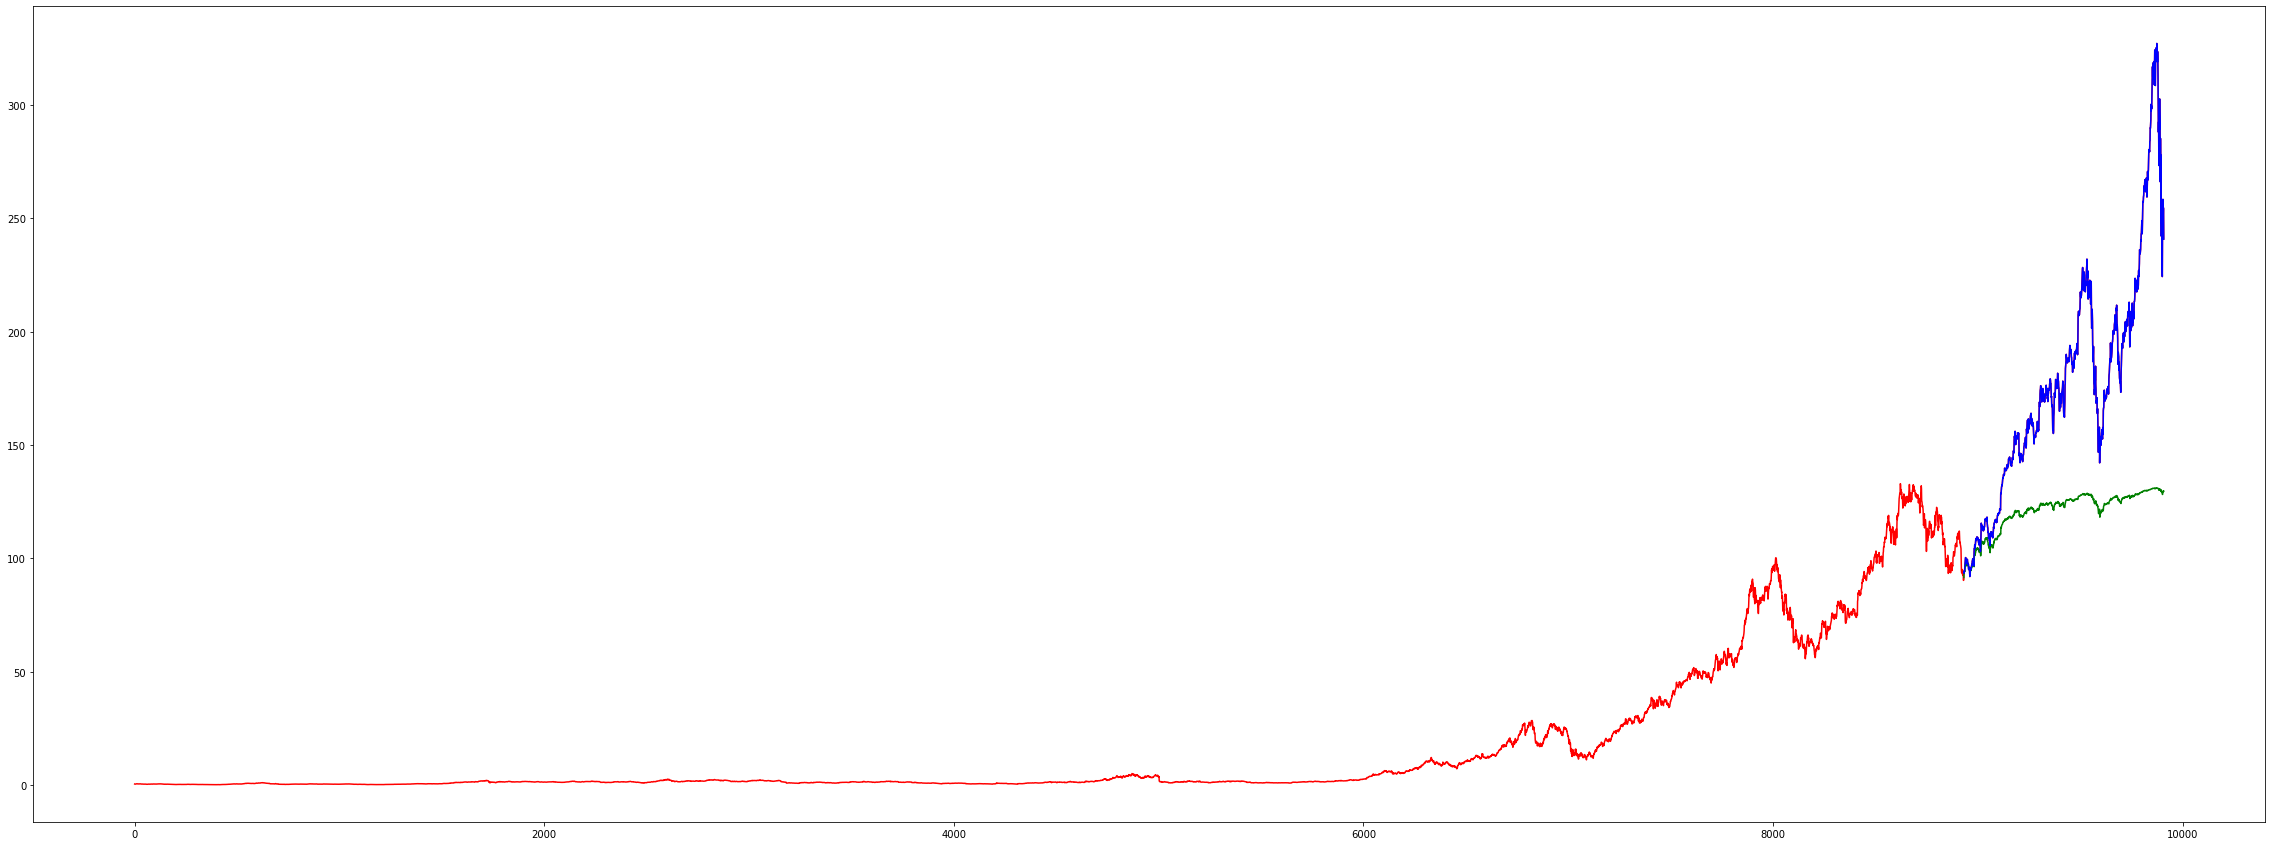

In [15]:
results = gru(path, train_test_split_ratio, lstm_config, (40, 15), (1, 14))